# Classification Model of Purchase Intentions
### DSCI100 Project Proposal Group 13

## Introduction
With e-commerce becoming more and more prevalent in today’s environment, businesses within this sector need to understand what factors influence a visitor to transform into a purchaser. Hence, a lot of current research is focused on real-time revenue predictors for these businesses.

This project uses a dataset from the UCI Machine Learning Repository called the Online Shoppers Purchasing Intention Dataset ([Sakar, C.O., Polat, S.O., Katircioglu, M. et al. 2018](#references)), which contains information about different users, such as the time spent in each web page and if that lead to a purchase or not.

The dataset consists of 12,330 rows of observations associated with 10 numerical and 8 categorical attributes. The dataset was formed so that each observation (session) would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.

The attributes in the dataset can be split into three categories: data related to the page that the user lands on, Google Analytics metrics, and user visit data. The 'Revenue' attribute determines whether a session ended in a purchase or not, and would be used as the class label for our project.

**In this project, we aim to build a classification model to predict the purchase intentions of prospective buyers, and determine whether they will make a purchase or not using the available website usage data. We would be using ProductRelated_Duration, PageValues and Administrative_Duration as our predictor variables for the classification. We have explained our choice of predictors and its reasoning in the analysis below.**

## Methods & Results:

### Importing libraries and reading data

In [23]:
# load packages
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

# set seed
set.seed(3456)

### Reading the data

In [24]:
# loading data from the original source on the web
shoppers_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv") %>%
            mutate(Revenue = as_factor(Revenue))
glimpse(shoppers_raw)

Parsed with column specification:
cols(
  Administrative = col_double(),
  Administrative_Duration = col_double(),
  Informational = col_double(),
  Informational_Duration = col_double(),
  ProductRelated = col_double(),
  ProductRelated_Duration = col_double(),
  BounceRates = col_double(),
  ExitRates = col_double(),
  PageValues = col_double(),
  SpecialDay = col_double(),
  Month = col_character(),
  OperatingSystems = col_double(),
  Browser = col_double(),
  Region = col_double(),
  TrafficType = col_double(),
  VisitorType = col_character(),
  Weekend = col_logical(),
  Revenue = col_logical()
)



Rows: 12,330
Columns: 18
$ Administrative          <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ProductRelated          <dbl> 1, 2, 1, 2, 10, 19, 1, 0, 2, 3, 3, 16, 7, 6, …
$ ProductRelated_Duration <dbl> 0.000000, 64.000000, 0.000000, 2.666667, 627.…
$ BounceRates             <dbl> 0.200000000, 0.000000000, 0.200000000, 0.0500…
$ ExitRates               <dbl> 0.200000000, 0.100000000, 0.200000000, 0.1400…
$ PageValues              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ SpecialDay              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.8, …
$ Month                   <chr> "Feb", "Feb", "Feb", "Feb", "Feb", "Feb", "Fe…
$ OperatingSystems        <dbl> 1, 2, 4, 3, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, …
$ Browser                 <

In [25]:
# check for missing data in dataset
missing_data <- shoppers_raw %>% summarize(missing_data = sum(is.na(.)))
missing_data

missing_data
<int>
0


### Tidying the data
From the data above `shoppers_raw` satisifies the three criteria of tidy data ([Wickham and others 2014](#references)): each row is a single observation, each column is a single variable, and each value is a single cell. Therefore, no further wrangling is needed to make it tidy. 

However, there are 8 categorical variables in the dataset that need to be excluded from our Knn classification.

In [26]:
shoppers <- shoppers_raw %>%
# set Revenue as a factor for classification
mutate(Revenue = as.factor(Revenue)) %>%
# removing categorical variables
select(- c(OperatingSystems, Browser, Region, TrafficType, VisitorType, Weekend, Month))

# show glimpse of resulting dataframe
glimpse(shoppers)

Rows: 12,330
Columns: 11
$ Administrative          <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ProductRelated          <dbl> 1, 2, 1, 2, 10, 19, 1, 0, 2, 3, 3, 16, 7, 6, …
$ ProductRelated_Duration <dbl> 0.000000, 64.000000, 0.000000, 2.666667, 627.…
$ BounceRates             <dbl> 0.200000000, 0.000000000, 0.200000000, 0.0500…
$ ExitRates               <dbl> 0.200000000, 0.100000000, 0.200000000, 0.1400…
$ PageValues              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ SpecialDay              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.8, …
$ Revenue                 <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…


Now the wrangled dataframe `shoppers` is ready for the next step.

### Splitting data into training and testing set
Since `shoppers` has a large amount (12330) of observations, it is splitted into a training set `shoppers_train` and a testing set `shoppers_test` with a 50/50 ratio.

In [27]:
# split data into training and testing sets, with predetermined 50/50 distribution and Revenue as the categorical label variable
shoppers_split <- initial_split(shoppers, prop = 1/2, strata = Revenue)
shoppers_train <- training(shoppers_split)
shoppers_test <- testing(shoppers_split)

head(shoppers_train)
head(shoppers_test)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0,0,0,1,0.000000,0.20,0.20000000,0,0,FALSE
0,0,0,0,1,0.000000,0.20,0.20000000,0,0,FALSE
0,0,0,0,2,2.666667,0.05,0.14000000,0,0,FALSE
0,0,0,0,10,627.500000,0.02,0.05000000,0,0,FALSE
1,0,0,0,0,0.000000,0.20,0.20000000,0,0,FALSE
0,0,0,0,3,395.000000,0.00,0.06666667,0,0,FALSE


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0,0,0,2,64.0000,0.00000000,0.10000000,0,0.0,FALSE
0,0,0,0,19,154.2167,0.01578947,0.02456140,0,0.0,FALSE
0,0,0,0,1,0.0000,0.20000000,0.20000000,0,0.4,FALSE
0,0,0,0,2,37.0000,0.00000000,0.10000000,0,0.8,FALSE
0,0,0,0,3,738.0000,0.00000000,0.02222222,0,0.4,FALSE
0,0,0,0,7,280.5000,0.00000000,0.02857143,0,0.0,FALSE


### Summarize the training set

In [28]:
# summarize the values in our numerical variables
summary(shoppers_train)

# determine the split of classifications in our label variable
training_set_revenue <- shoppers_train %>%
 group_by(Revenue) %>%
 summarize(
 count = n()
 )
training_set_revenue

 Administrative   Administrative_Duration Informational   
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.000  
 Median : 1.000   Median :  11.00         Median : 0.000  
 Mean   : 2.375   Mean   :  83.92         Mean   : 0.517  
 3rd Qu.: 4.000   3rd Qu.:  97.80         3rd Qu.: 0.000  
 Max.   :27.000   Max.   :3398.75         Max.   :24.000  
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  186.7        
 Median :   0.00        Median : 18.00   Median :  605.7        
 Mean   :  35.14        Mean   : 32.42   Mean   : 1237.2        
 3rd Qu.:   0.00        3rd Qu.: 38.00   3rd Qu.: 1485.6        
 Max.   :2549.38        Max.   :705.00   Max.   :63973.5        
  BounceRates        ExitRates         PageValues        SpecialDay     
 Min.   :0.00000   Min.   :0.00000   Min.   :  0.000   Min.

`summarise()` ungrouping output (override with `.groups` argument)



Revenue,count
<fct>,<int>
FALSE,5211
TRUE,954


### Visualization of the dataset

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



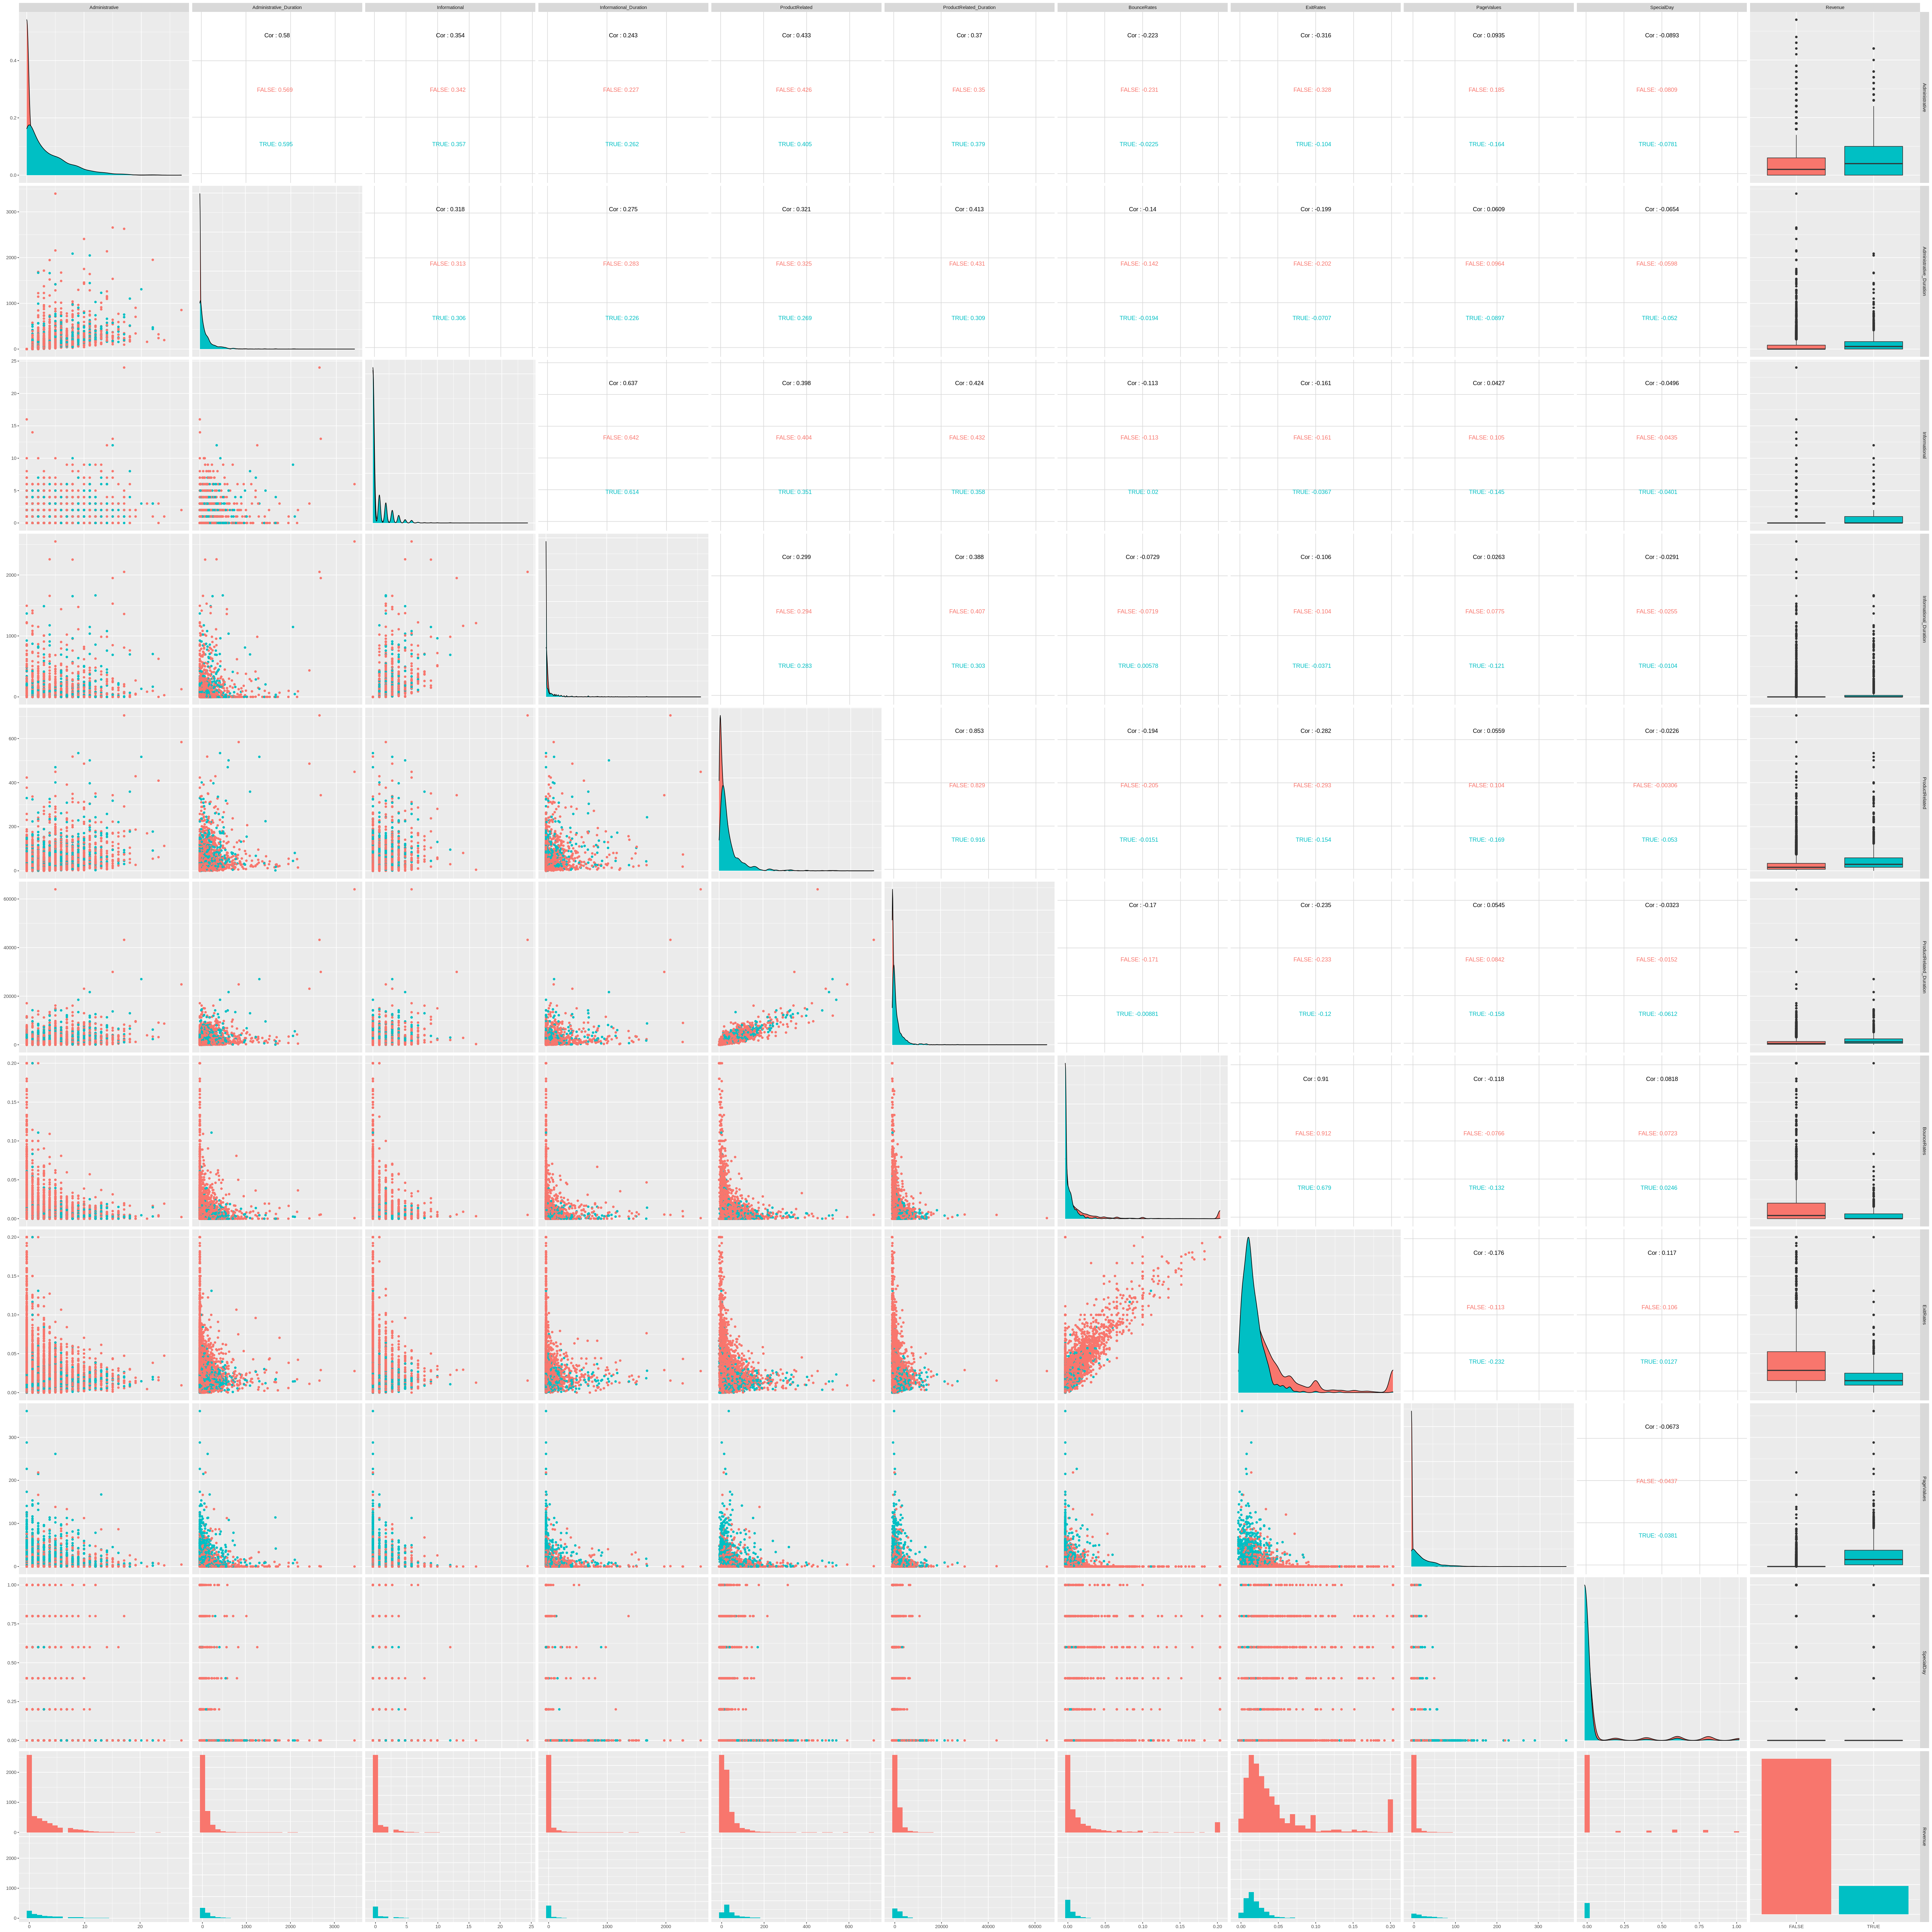

In [29]:
options(repr.plot.height = 50, repr.plot.width = 50)
# visualizing training set, using ggpairs to determine trends between variables
shopper_eda <- ggpairs(shoppers_train, aes(colour=Revenue)) +
               labs(color = "Revenue")
shopper_eda

We have used the `ggpairs()` function from the GGally package to explore the relationships between the different variables in the dataset.

## Data Analysis:

### Balancing Data

From the summary of the dataset, we observe that our data is quite imbalanced. Hence, we would be upsampling our “true” values of the Revenue class to avoid our model being biased against predicting it.

In [30]:
# create recipe for balancing our dataset
ups_recipe <- recipe(Revenue ~ ., data = shoppers_train) %>% 
  step_upsample(Revenue, over_ratio = 1, skip = FALSE) %>% 
  prep()
ups_recipe

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         10

Training data contained 6165 data points and no missing data.

Operations:

Up-sampling based on Revenue [trained]

In [31]:
# bake recipe to apply the balancing
shoppers_train <- bake(ups_recipe, shoppers_train)

# verify the results of balancing
shoppers_train %>% 
  group_by(Revenue) %>% 
  summarize(n = n())

`summarise()` ungrouping output (override with `.groups` argument)



Revenue,n
<fct>,<int>
FALSE,5211
TRUE,5211


### Selecting predictors using forward selection

In [11]:
# create a new dataframe from the training set
shoppers_subset <- shoppers_train
# store column names as variables, ignoring label variable
names <- colnames(shoppers_subset %>% select(-Revenue))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(shoppers_subset, v = 5, strata = Revenue)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Revenue", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        shoppers_recipe <- recipe(as.formula(model_string), data = shoppers_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors()) 

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(shoppers_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = cancer_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Revenue ~ ProductRelated_Duration,0.8955106
2,Revenue ~ ProductRelated_Duration+PageValues,0.9398387
3,Revenue ~ ProductRelated_Duration+PageValues+Administrative_Duration,0.9449254
⋮,⋮,⋮
8,Revenue ~ ProductRelated_Duration+PageValues+Administrative_Duration+ExitRates+SpecialDay+BounceRates+Informational+Informational_Duration,0.9499140
9,Revenue ~ ProductRelated_Duration+PageValues+Administrative_Duration+ExitRates+SpecialDay+BounceRates+Informational+Informational_Duration+Administrative,0.9456918
10,Revenue ~ ProductRelated_Duration+PageValues+Administrative_Duration+ExitRates+SpecialDay+BounceRates+Informational+Informational_Duration+Administrative+ProductRelated,0.9425261


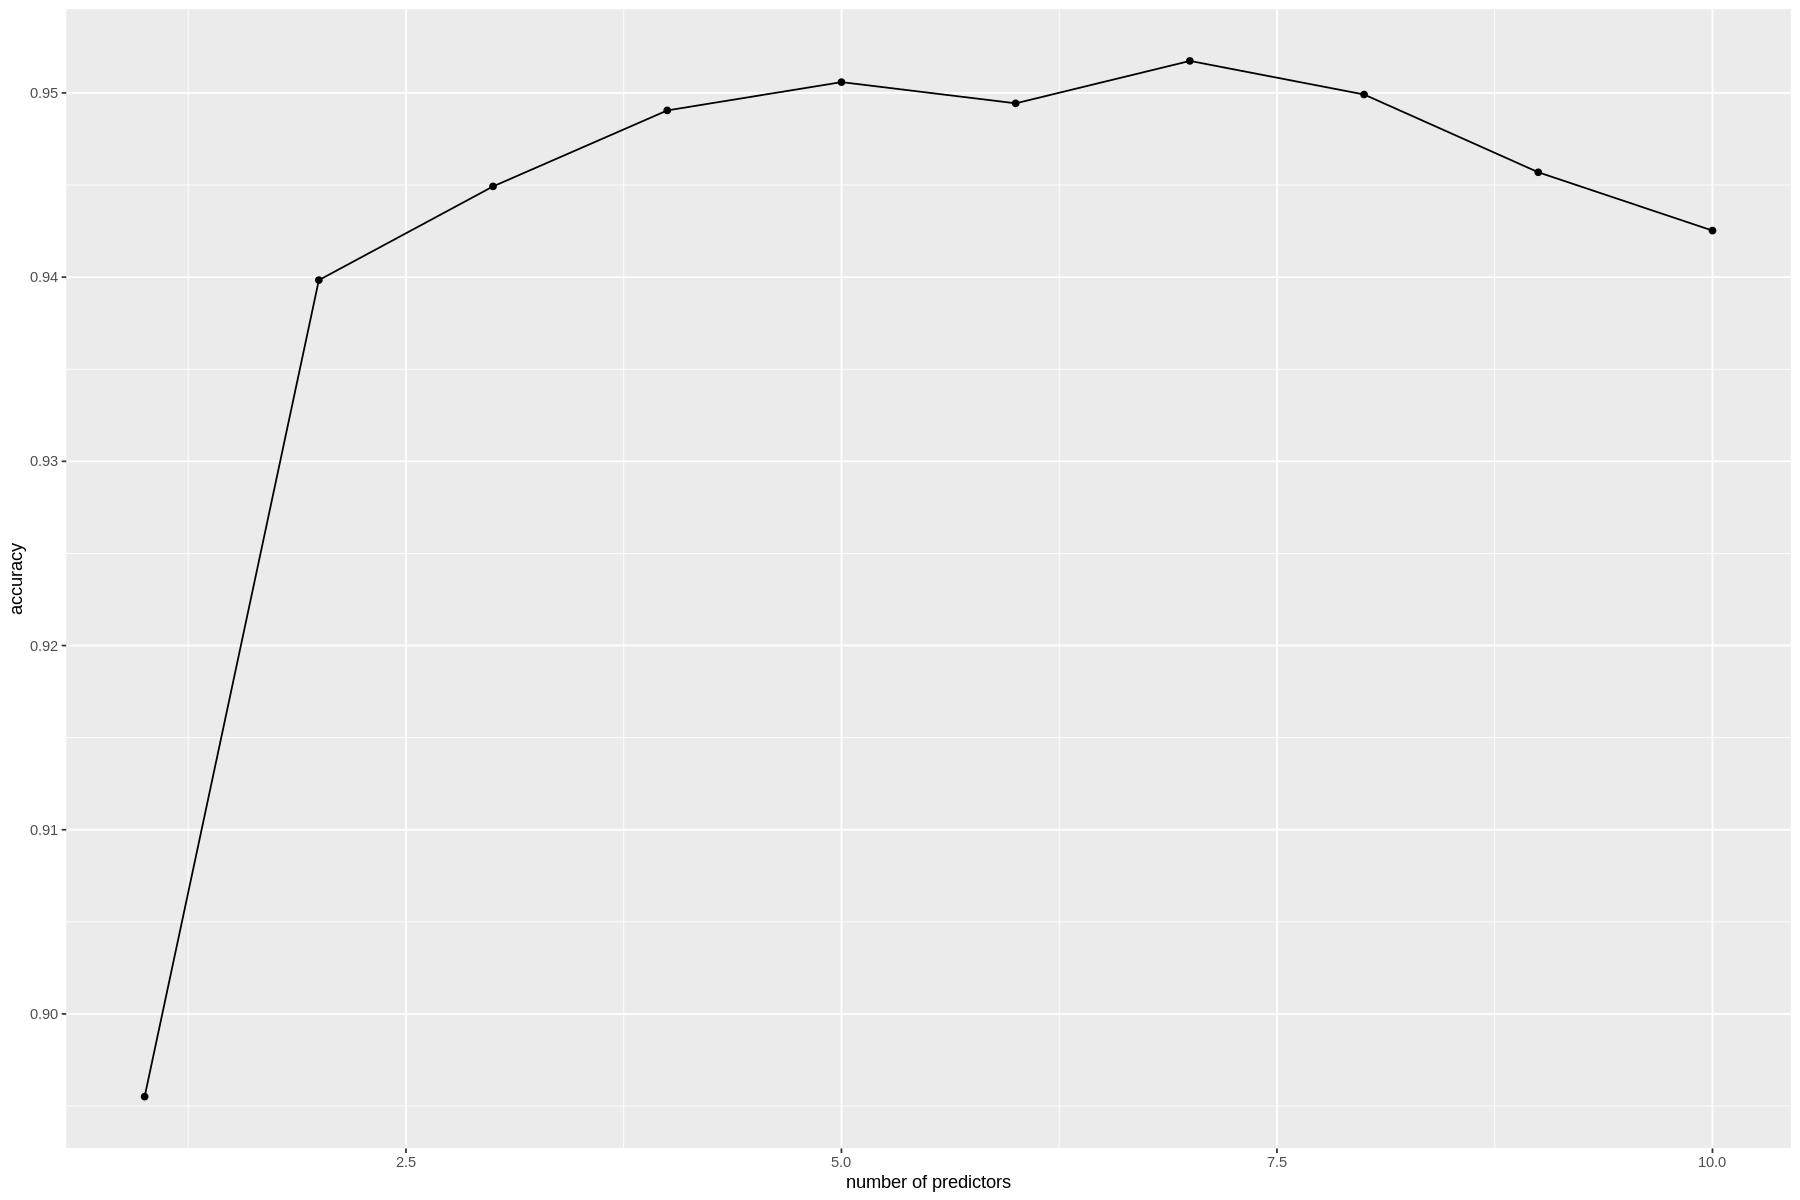

In [14]:
options(repr.plot.height = 10, repr.plot.width = 15)

# plot the accuries of the different combinations of predictors to determine the most suitable set of predictors
accuracies_plot <- accuracies %>%
                   ggplot(aes(x = size, y = accuracy)) +
                   geom_point() +
                   geom_line() +
                   labs(x = "number of predictors", y = "accuracy")
accuracies_plot

From the graph, we see that the model hits an elbow point and the accuracy starts to level off and fluctuates after 3 predictors. Hence, that is the set of predictors we would be using for our analysis. 

Therefore, our prediction model would be: 

**Revenue ~ ProductRelated_Duration + PageValues + Administrative_Duration**, where,  

**ProductRelated_Duration**: Total amount of time (in seconds) spent by the visitor on product related pages,

**PageValues**: Average page value of the pages visited by the visitor as measured by "Google Analytics" metrics for each page in the e-commerce site,

**Administrative_Duration**: Total amount of time (in seconds) spent by the visitor on account management related pages. ([Kabir, Md Rayhan & Ashraf, Faisal & Ajwad, Rasif 2019](#references))

### Parameter value selection (K value) for classification

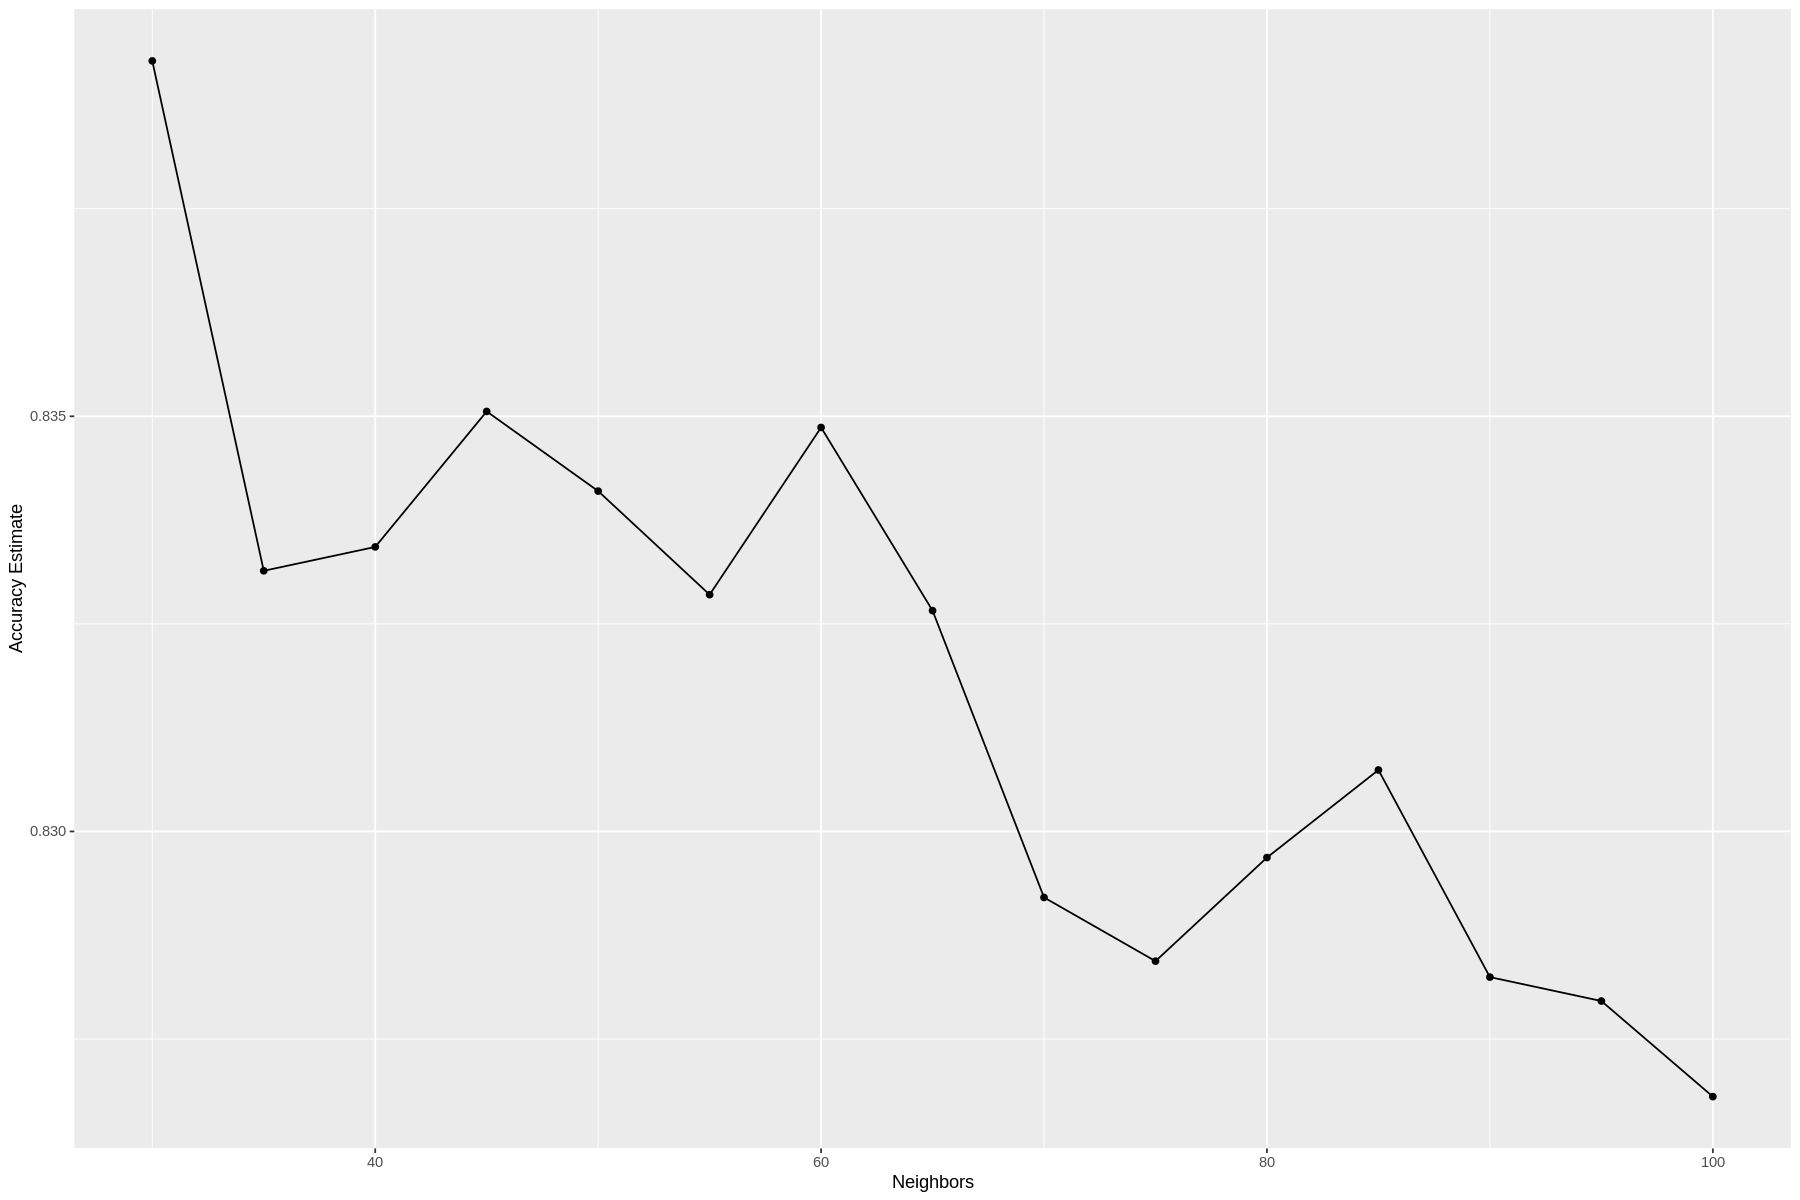

In [32]:
# set seed
set.seed(1234) 

options(repr.plot.height = 10, repr.plot.width = 15)

# create a recipe with standardization for cross-validation on training set
training_recipe <- recipe(Revenue ~ ProductRelated_Duration + PageValues + Administrative_Duration
                          , data = shoppers_train) %>% 
                   step_scale(all_predictors()) %>% 
                   step_center(all_predictors())

# perform 10-fold cross-validation
training_vfold <- vfold_cv(shoppers_train, v = 10, strata = Revenue)

# create knn classification model for tuning
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

# try it in sequence from 1 to 385 in the first iteration
# k_lots <- tibble(neighbors = seq(from = 1, to = 385, by = 10))

# zoom in to narrow down the range of values based on the observations in the first iteration
k_lots <- tibble(neighbors = seq(from = 30, to = 100, by = 5))

# store results of tuning using workflow(), tune_grid(), and collect_metrics()
knn_results <- workflow() %>%
       add_recipe(training_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = training_vfold, grid = k_lots) %>%
       collect_metrics ()

# filter for the accuracy in the results
knn_accuracy <- knn_results %>% 
        filter(.metric == "accuracy")

# plot accuracy against number of neighbors
cross_val_plot <- ggplot(knn_accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

From the graph we see that the model significantly overfits until k = 30 (, hence the large drop in accuracy). Thereforefore, we would be using k = 50 as our parameter value since it is the local maximum (ignoring overfitting) with minimal fluctuations.

In [36]:
kval <- 50
kval

[1] 50

### Training the model

In [37]:
# create knn classification model with optimum number of neighbors 
shoppers_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kval) %>%
                 set_engine("kknn") %>%
                 set_mode("classification")

# fit model and recipe to training set
shoppers_fit <- workflow() %>%
                add_recipe(training_recipe) %>%
                add_model(shoppers_spec) %>%
                fit(data = shoppers_train)

shoppers_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~kval,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1634043
Best kernel: rectangular
Best k: 50

### Predicting the testing data

In [38]:
# predict data of testing set using classification model
shoppers_test_predictions <- predict(shoppers_fit, shoppers_test) %>%
bind_cols(shoppers_test)
shoppers_test_predictions

.pred_class,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
FALSE,0,0,0,0,2,64.0000,0.00000000,0.1000000,0,0.0,FALSE
FALSE,0,0,0,0,19,154.2167,0.01578947,0.0245614,0,0.0,FALSE
FALSE,0,0,0,0,1,0.0000,0.20000000,0.2000000,0,0.4,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,0,0,0,0,5,465.75,0.00000000,0.02133333,0,0,FALSE
FALSE,0,0,0,0,6,184.25,0.08333333,0.08666667,0,0,FALSE
FALSE,0,0,0,0,3,21.25,0.00000000,0.06666667,0,0,FALSE


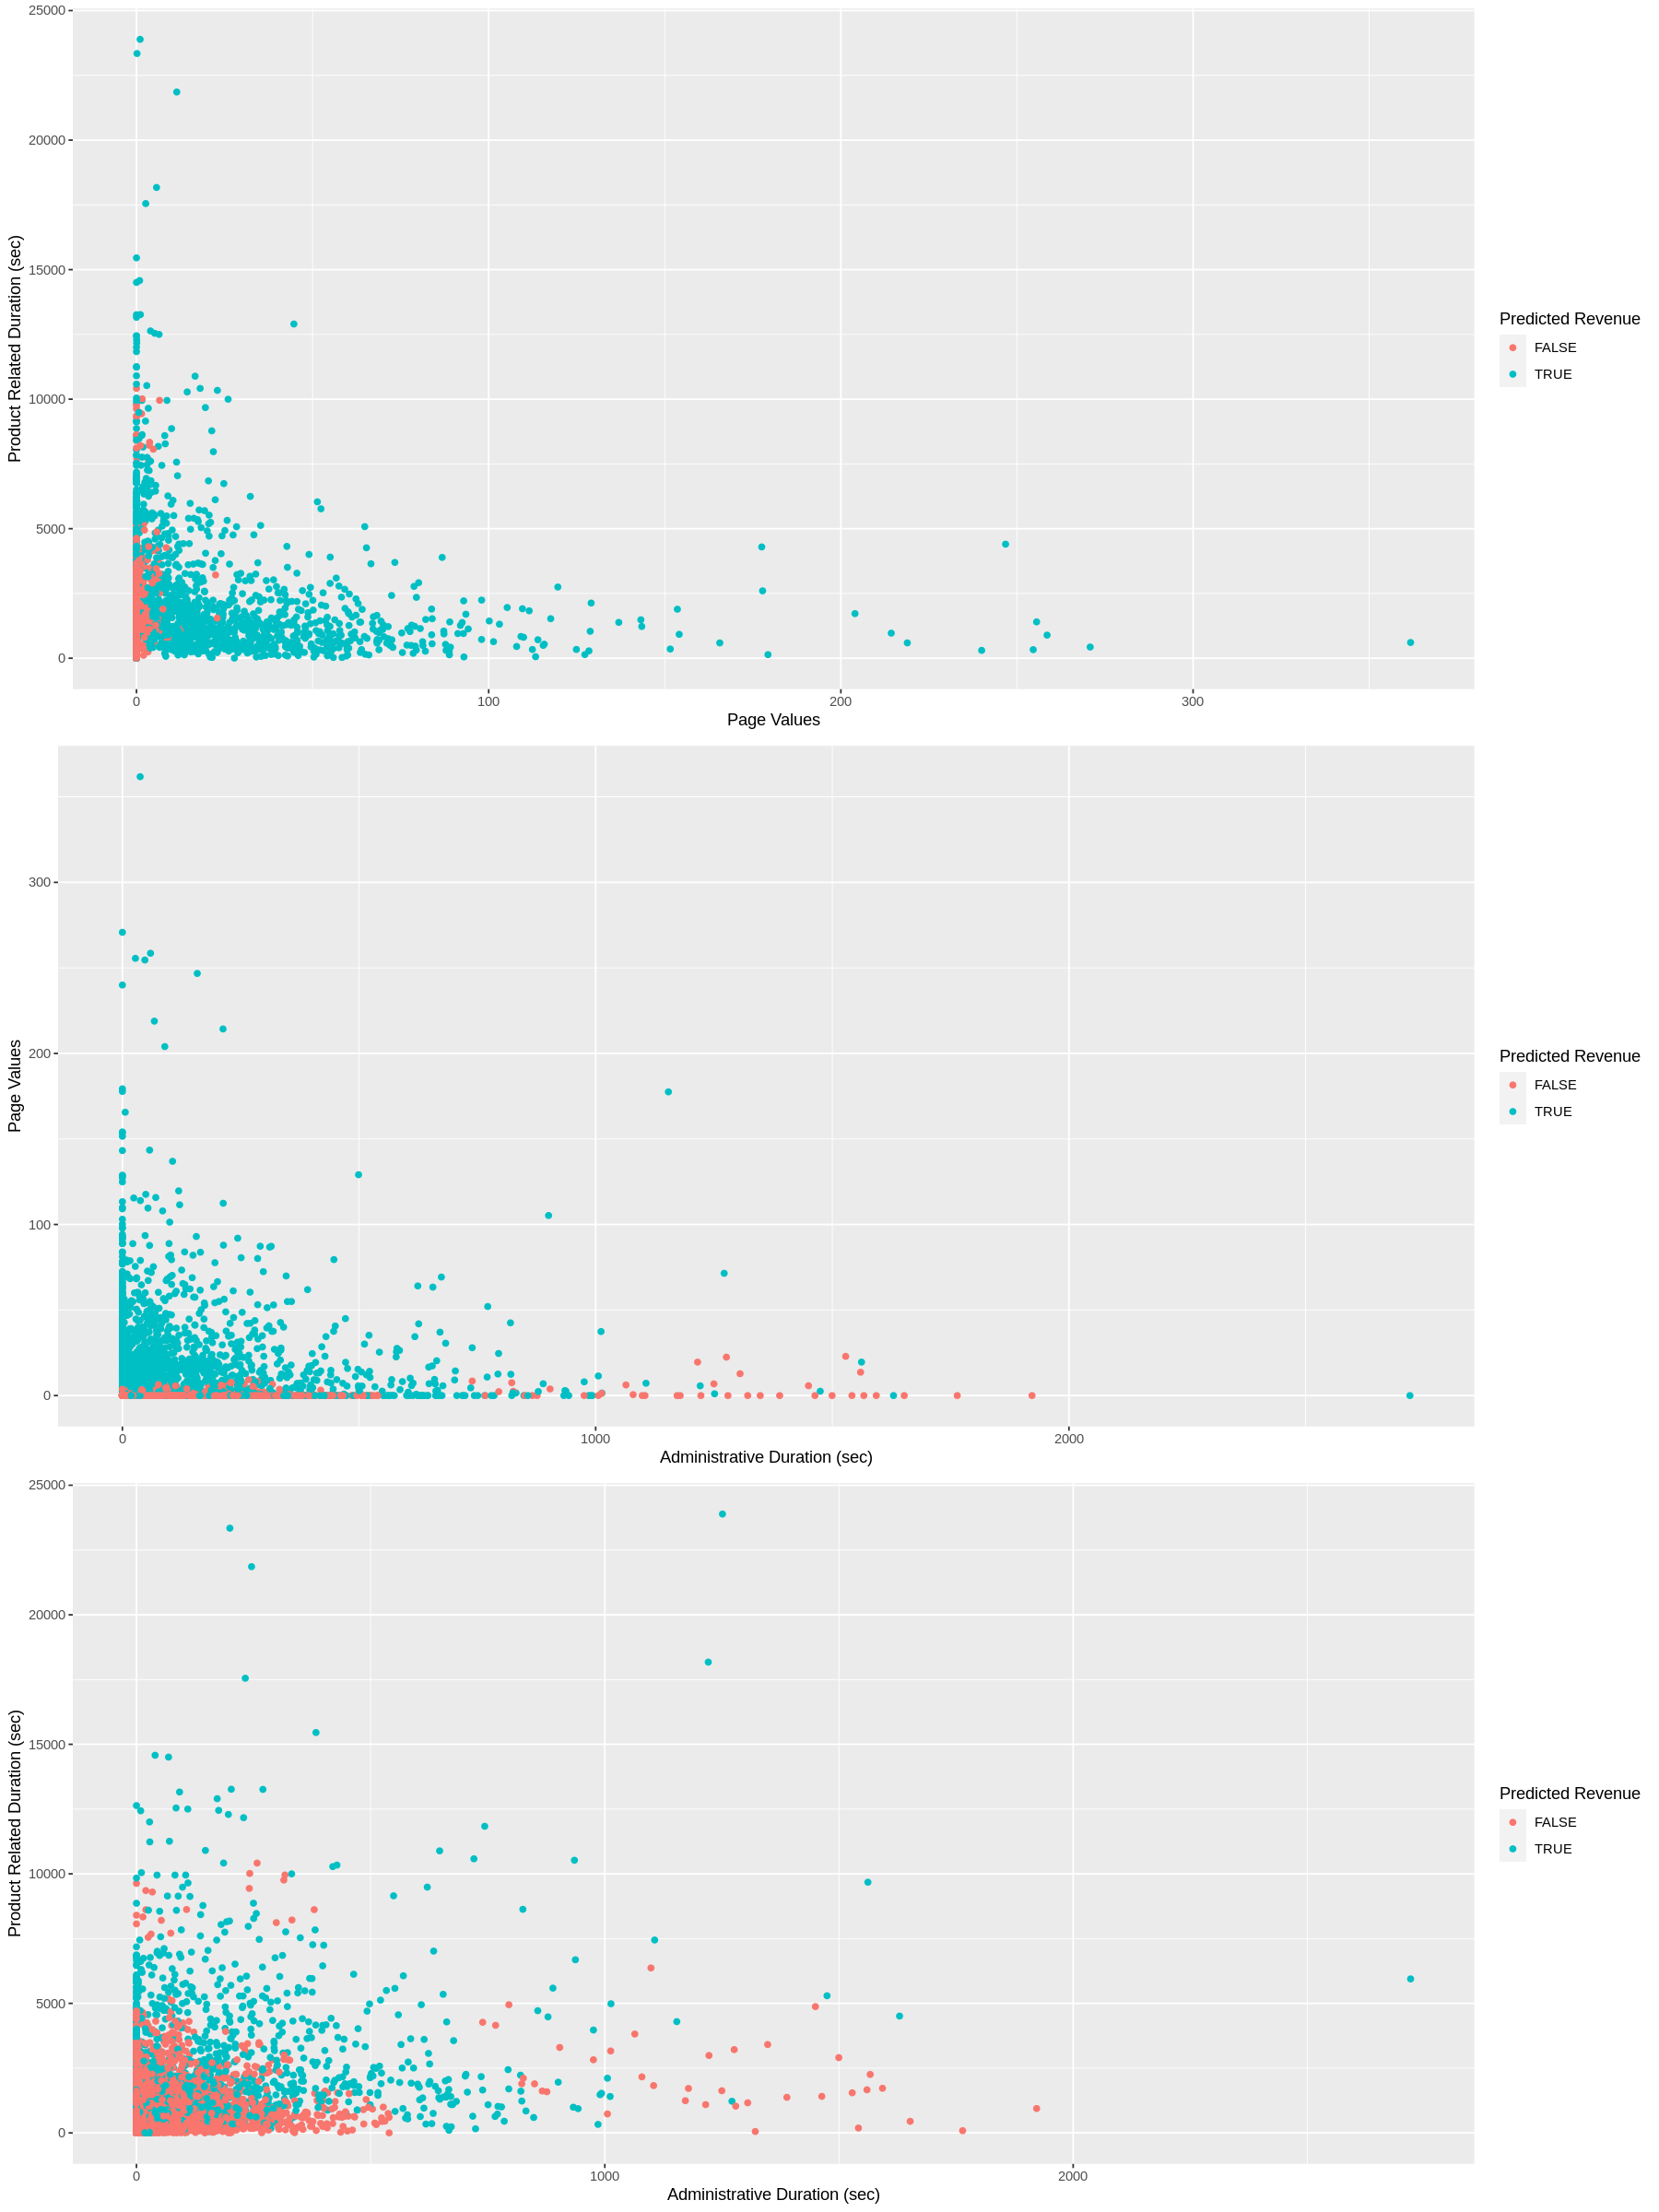

In [43]:
# Visualizing the predicted revenue
ProductRelated_Duration_vs_PageValues <- shoppers_test_predictions %>%
  ggplot(aes(x = PageValues, y = ProductRelated_Duration, color = .pred_class)) +
  geom_point() +
  labs(x = "Page Values", y = "Product Related Duration (sec)", color = "Predicted Revenue")

PageValues_vs_Administrative_Duration <- shoppers_test_predictions %>%
  ggplot(aes(x = Administrative_Duration, y = PageValues, color = .pred_class)) +
  geom_point() +
  labs(x = "Administrative Duration (sec)", y = "Page Values", color = "Predicted Revenue")

ProductRelated_Duration_vs_Administrative_Duration <- shoppers_test_predictions %>%
  ggplot(aes(x = Administrative_Duration, y = ProductRelated_Duration, color = .pred_class)) +
  geom_point() +
  labs(x = "Administrative Duration (sec)", y = "Product Related Duration (sec)", color = "Predicted Revenue")

options(repr.plot.width = 15, repr.plot.height = 20)
plot_grid(ProductRelated_Duration_vs_PageValues, 
          PageValues_vs_Administrative_Duration, 
          ProductRelated_Duration_vs_Administrative_Duration,
          nrow = 3)

### Evaluating the accuracy of our classifier

In [60]:
# calculate accuracy of predictions  
shoppers_test_predictions %>% 
  metrics(truth = Revenue, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8510949
kap,binary,0.5318154


In [61]:
# visualize confusion matrix to analyze prediction results 
confusion <- shoppers_test_predictions %>% 
             conf_mat(truth = Revenue, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE  4500  207
     TRUE    711  747

## Methodology:

We start off our analysis by reading the data from the source. Then we inspect the format of the data and check if there is any missing data to verify whether the data is in tidy format or not. As explained earlier, upon inspection our data is found to be in tidy format. Hence, we move onto preparing the data for the analysis. 

In order to prepare the data for the analysis, we then remove the categorical variables from our dataset as they are irrelevant for our classification. Then we split our data into a training and testing set with Revenue as the strata for the classification. The split ratio was determined to be 50/50 due to the large size of our data. If our data frame was smaller, then this ratio could result in a biased model that is heavily reliant on what rows happened to be selected for training. However, half of our database is still 6165 rows which will be sufficient for providing a large enough sample for training.

We then summarize our training set to observe the data. We first observe the range of values in our numerical variables using the summary() function. This shows us that the variables are on different scales and would be affecting our classification if not standardized properly. Hence, we perform standardization later on during our data analysis. In our summary, we also observe the split of classifications in our label variable, which shows us that the data is quite imbalanced against our “true” classifications. Hence, we upsample our “true” values of the Revenue class during the data analysis to avoid our model being biased against predicting it. We then visualize our training set to observe the relationships between the different variables in our dataset.

Then we move onto performing the data analysis, where we start off by balancing our training data. Then we use the training data to perform forward selection to help us choose the optimal set of predictors for our analysis. From our forward selection, we found that the predictor combination of (ProductRelated_Duration + PageValues + Administrative_Duration) would be optimal for predicting the revenue without introducing the noise from irrelevant variables. The reasoning and explanation for this is described above.

We then use our predictor combination to move onto performing the knn classification of our label variable. We start by determining the optimal parameter (k) value for our classifier model using 10-fold cross validation and grid value tuning. We use a large sequence of numbers as our grid values and optimize the model based on the accuracy metric of our tuning results. To visualize the data we plot the accuracy of the different parameter values in the grid and then zoom in the grid to accurately determine the k value. This was found to be k = 50 in our case. Further explanation of the functionality of code is provided within the comments.

We then train a knn classification model based on the optimal k value from before, and fit it to our training dataset. We then use this model to predict the data in the testing set. The accuracy and effectiveness of the classifier is then determined using the metrics() and conf_mat() function for analysis.


## Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## <a id='references'></a>References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

- Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). Online Shoppers Purchasing Intention Dataset Data Set. [Data file] Retrieved from http://https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset
- Wickham, Hadley, and others. 2014. “Tidy Data.” Journal of Statistical Software 59 (10): 1–23.
- Kabir, Md Rayhan & Ashraf, Faisal & Ajwad, Rasif. (2019). Analysis of Different Predicting Model for Online Shoppers’ Purchase Intention from Empirical Data. 

- Cue consistency and page value perception: Implications for web-based catalog design.
- Analysis of Queues with Impatient Clients: An Application to Online Shopping